# Data Analytics

In [2159]:
# importing libraries
import requests
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Crawl Dataset

Perform web scraping on *Yahoo Finance* to obtain daily stock data of Nvidia (Ticker: NVDA) from 1 January 2021 to 31 December 2023.

The variables of interest in the dataset include: (in the context of daily stock data)
- Date: The date in which the stock data is recorded.
- Open: The price of the stock when the market opens.
- High: The stock's highest traded price during the trading day.
- Low: The stock's lowest traded price during the trading day.
- Close: The price of the stock when the market closes.
- Adjusted Close: The closing price after adjustments from dividends, stock splits, etc. have been taken into account.
- Volume: The number of shared traded on the trading day.

As shown in the code below, the dataset was collected using web scraping with the help of the `requests` Python library. The target URL was set to fetch the historical daily stock data of NVDA for the time period from January 1, 2021 to December 31, 2023 from Yahoo Finance. The `requests.get()` method was then used to send a `GET` request to Yahoo Finance. Notice that we specify the parameter `headers={'User-Agent':'Mozilla/5.0'}`. This is used to mimic a browser request, thus ensuring that we can bypass any restrictions imposed by the website.

Once we have retrieved the HTML content of the webpage, we use `pandas.read_html()` method to parse/convert the HTML formatted-table  into Pandas DataFrame.

In [703]:
# scrape stock data
url = 'https://finance.yahoo.com/quote/NVDA/history/?period1=1609459200&period2=1703980800'
r = requests.get(url, headers={'User-Agent':'Mozilla/5.0'})

In [705]:
# covert html table into dataframe
read_html_pandas_data = pd.read_html(r.text)[0]
read_html_pandas_data

,Date,Open,High,Low,Close Close price adjusted for splits.,Adj Close Adjusted close price adjusted for splits and dividend and/or capital gain distributions.,Volume
0,"Dec 29, 2023",49.81,50.00,48.75,49.52,49.51,389293000
1,"Dec 28, 2023",49.64,49.88,49.41,49.52,49.51,246587000
2,"Dec 27, 2023",49.51,49.68,49.08,49.42,49.41,233648000
3,"Dec 26, 2023",48.97,49.60,48.96,49.28,49.27,244200000
4,"Dec 22, 2023",49.19,49.38,48.47,48.83,48.82,252507000
...,...,...,...,...,...,...,...
761,"Jan 8, 2021",13.36,13.42,13.04,13.28,13.24,292528000
762,"Jan 7, 2021",12.97,13.38,12.89,13.34,13.31,461480000
763,"Jan 6, 2021",13.22,13.24,12.59,12.61,12.58,580424000
764,"Jan 5, 2021",13.10,13.44,13.09,13.40,13.37,322760000


In [707]:
# export dataframe to CSV file
read_html_pandas_data.to_csv('NVDA_stock_data.csv', index=False)

## 2a.  Data Preparation & Cleaning

In [2450]:
# create a copy
df = read_html_pandas_data.copy()

In [2452]:
# renaming the columns
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [2454]:
# the number of rows
print(f'Number of rows: {df.shape[0]}')

# the number of columns
print(f'Number of columns: {df.shape[1]}')

Number of rows: 766
Number of columns: 7


In [2456]:
# Checking for nulls in the table
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

There are no null values in the table.

In [2459]:
# Check the data type for each row
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       766 non-null    object
 1   Open       766 non-null    object
 2   High       766 non-null    object
 3   Low        766 non-null    object
 4   Close      766 non-null    object
 5   Adj Close  766 non-null    object
 6   Volume     766 non-null    object
dtypes: object(7)
memory usage: 42.0+ KB


We observe that all of the columns have the data type `object`, even though we would expect the the `Date` column to have `datetime` data type, `Volume` column to have an `int` or `float` data type, and the rest of the columns to have `float` data type.

### Date column

Let's start with the `Date` column. Firstly, we check each row in the column, ensuring that they are all dates but with object data type.

In [2463]:
# count the number of rows that cannot be converted to datetime
pd.to_datetime(df['Date'], errors='coerce').isnull().sum()

0

Based on the result above, we can confirm that the rows in the `Date` column are all dates but with object data type (i.e. all rows can be converted to datetime data type).

So the logical next step is to convert the `Date` column's data type into `datetime`,

In [2466]:
# convert data type to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

### The rest of the columns

Now, let's take a closer look at the data in the `Open`, `High`, `Low`, `Close`, `Adj Close`, and `Volume` columns.

We begin by checking for non-numeric entries in these columns.

In [2469]:
# create a copy of df to only store numerical columns
df_num = df.copy()

# drop the Date column
df_num.drop('Date', axis=1, inplace=True)

# store numeric columns (to be used later)
num_cols = df_num.columns

In [2471]:
# create a copy of df
df_bool = df_num.copy()

# indicate the rows in each column that are non-numeric
for col in df_num.columns:
    df_bool[col] = pd.to_numeric(df_num[col], errors='coerce').isnull()

# locate rows in the dataframe that contain at least 1 non-numeric value
ser_bool = df_bool.any(axis=1)

# print an extract of the dataframe with rows that contain at least 1 non-numeric value
df_num = df_num[ser_bool]
display(df_num)

,Open,High,Low,Close,Adj Close,Volume
17,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend
81,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend
144,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend
209,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend
275,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend
335,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend
398,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend
467,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend
530,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend
595,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend


From the result above, we can see the rows that contain a least 1 numeric values. Notice that in every column, there are entries that are non-numerical, which explains the reason that Pandas assigns the `object` data type to these columns.

Before we drop these rows, we will take a look at any other data entries with the same date as these dividend payment / stock split events.

In [2475]:
# the list of dates when non-numeric entries are provided
date_non_numeric = list(df.loc[df_num.index, 'Date'])

# display all data in those dates
filetered_df = df.where(df['Date'].isin(date_non_numeric)).dropna()
display(filetered_df)

,Date,Open,High,Low,Close,Adj Close,Volume
17,2023-12-05,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend
18,2023-12-05,45.47,46.60,45.27,46.57,46.56,371718000
81,2023-09-06,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend
82,2023-09-06,48.44,48.55,46.58,47.06,47.05,468670000
144,2023-06-07,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend
145,2023-06-07,38.92,39.50,37.36,37.47,37.46,511998000
209,2023-03-07,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend
210,2023-03-07,23.60,24.13,23.24,23.29,23.28,515154000
275,2022-11-30,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend,0.00 Dividend
276,2022-11-30,15.70,16.93,15.60,16.92,16.91,565298000


It seems that, at the dates when dividend payment / stock split event occur, there is also stock price and volume data.

Moreover, I want to take a closer look at the stock split event to check whether the prices before and after the split are consistent.

In [2478]:
# extract date of stock split
bool_split = df['Open'].str.contains('Stock Splits')
date_split = df[bool_split]['Date']
date_split

626   2021-07-20
Name: Date, dtype: datetime64[ns]

The split happened on July 20th, 2021. To see whether the prices before and after the split are consistent, we will print a few rows of data, before and after the split date,

In [2481]:
# index of the stock split date
idx_split = date_split.index[0]

# print a few rows before and after the split
df.iloc[idx_split-3 : idx_split+4, :]

,Date,Open,High,Low,Close,Adj Close,Volume
623,2021-07-23,19.66,19.70,19.25,19.56,19.52,195672000
624,2021-07-22,19.64,19.89,19.28,19.59,19.56,323826000
625,2021-07-21,18.88,19.53,18.74,19.41,19.37,371017000
626,2021-07-20,4:1 Stock Splits,4:1 Stock Splits,4:1 Stock Splits,4:1 Stock Splits,4:1 Stock Splits,4:1 Stock Splits
627,2021-07-20,18.73,18.84,18.16,18.61,18.58,434687000
628,2021-07-19,17.92,19.04,17.87,18.78,18.74,749060000
629,2021-07-16,19.03,19.16,18.07,18.16,18.13,688224000


The prices before and after the stock split appear to be consistent (i.e. the prices have been adjusted). Therefore, so no further action is required (such as dividing or multipltying the price by 4 for a 4:1 stock split).

Lastly, we are going to store the date when dividend payment was made, (This is to be used later for Feature Generation.)

In [2485]:
# extract date of stock split
bool_divd = df['Open'].str.contains('Dividend')
date_divd = df[bool_divd]['Date']
date_divd

17    2023-12-05
81    2023-09-06
144   2023-06-07
209   2023-03-07
275   2022-11-30
335   2022-09-07
398   2022-06-08
467   2022-03-02
530   2021-12-01
595   2021-08-31
655   2021-06-09
720   2021-03-09
Name: Date, dtype: datetime64[ns]

Now let's drop these non-numeric rows,

In [2488]:
# drop non-numeric rows
df.drop(df_num.index, axis=0, inplace=True)

The next step is to change the data type of these numeric columns to float/integer,

In [2491]:
# change data type of numeric columns to 
for col in num_cols:
    df[col] = pd.to_numeric(df[col])

In [2493]:
# check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 753 entries, 0 to 765
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       753 non-null    datetime64[ns]
 1   Open       753 non-null    float64       
 2   High       753 non-null    float64       
 3   Low        753 non-null    float64       
 4   Close      753 non-null    float64       
 5   Adj Close  753 non-null    float64       
 6   Volume     753 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 47.1 KB


The data type has been appropriately changed.

For convenience, we will change the order of the dataframe, so that it is ordered based on the `Date` column in ascending order,

In [2497]:
df.sort_values('Date', ascending=True, inplace=True)

Use the `Date` column as the index for the dataframe,

In [2500]:
# use Date column as the dataframe index
df.set_index('Date', inplace=True)

### Outliers

We are now going to check for outliers/anomalies in the dataset, with the primary goal to detect unrealistic price points or volume spikes.

We start with creating a histogram to get an overview of the distribution of the data points.

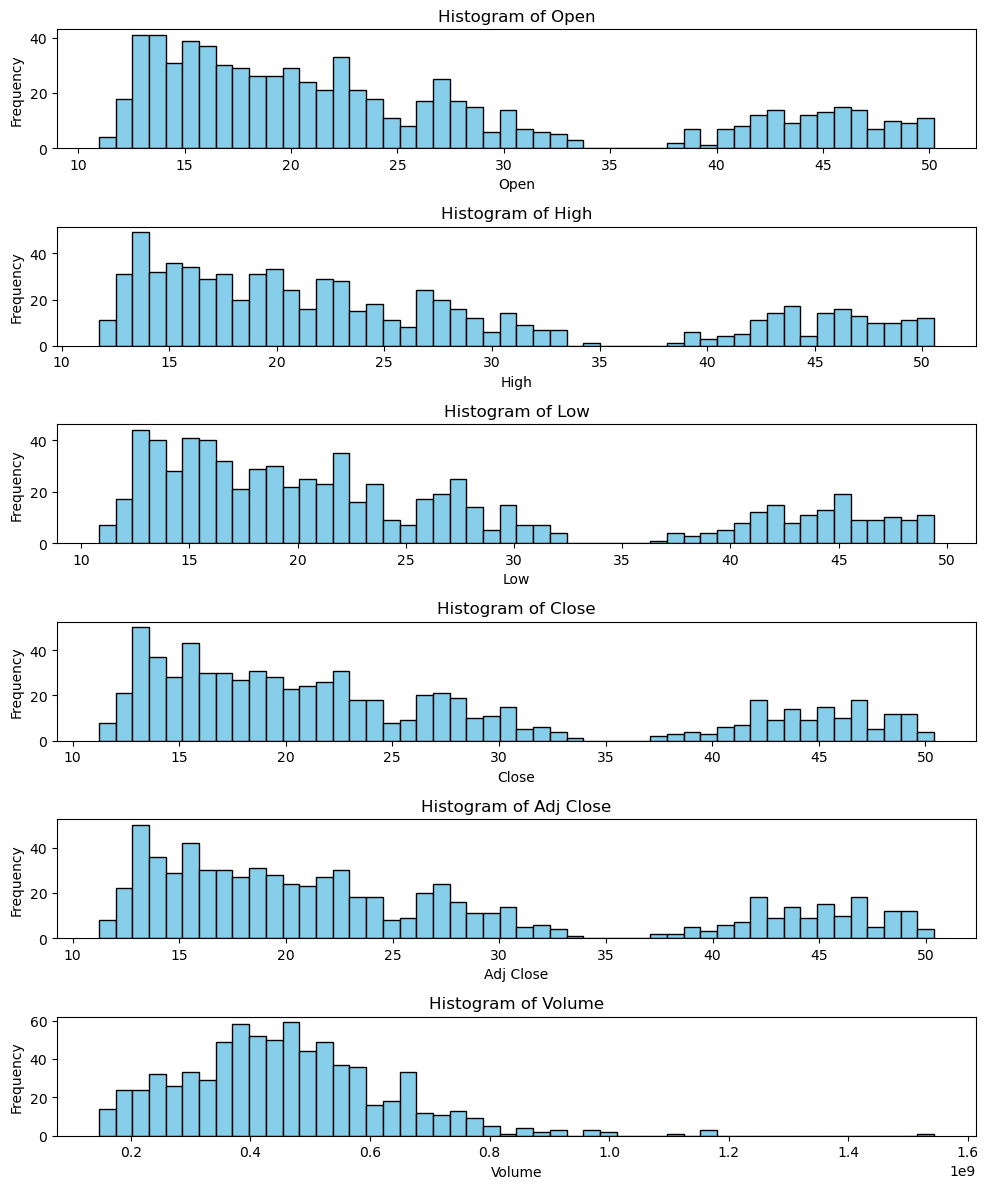

In [2503]:
# create histogram
fig, ax = plt.subplots(6, 1, figsize=(10, 12))
# loop thorugh each columns
for i, col in enumerate(df.columns):
    ax[i].hist(df[col], bins=50, color='skyblue', edgecolor='black')
    ax[i].set_title(f'Histogram of {col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Frequency')

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

For price data (including Open, High, Low, Close, and Adj Close), we observe that the price was generally trading around \\$10 to \\$50. We do not observe any unrealisticly price movements, such as the price dropping to $0 or spiking to extreme levels (such as to the hundreds or thousands), which suggests the the data is free from such obvious errors. Moreover, we also observe that the distribution of Open, High, Low, Close, and Adj Close prices are closely matching each other, which is what we wanted and expected to see.

For volume data, we observe that the daily traded volume is mostly around 500,000,000 shares. However, we do observe several data points that are well above the 1,000,000,000 shares. These higher volume amount are significantly above the usual daily traded volume, which could either be caused by unusual market activity or erroneous data.

To have a more concrete analysis, we are going to use the Tukey's Fences method for outlier detection. The reason for choosing this method over other methods (such as the 3$\sigma$ Rule) is because it is robust and non-parametric, which is ideal with our dataset that is not normally distributed (as shown in the histograms before).

With this rule, an upper and lower bound are defined. The upper bound is the Q3 plus 1.5 times the IQR; The lower bound is the Q1 minus 1.5 times IQR. Any data points that are above the upper bound or below the lower bound are defined as the outlier.

In [2515]:
# Tukey's Fences method
def tukeys_fences(col):
    Q1 = np.percentile(col, 25)  # first quartile
    Q3 = np.percentile(col, 75)  # third quartile
    IQR = Q3 - Q1  # interquartile range
    # compute the lower and upper boundary
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # define outliers
    outliers = col[(col < lower_bound) | (col > upper_bound)]
    return outliers

# apply Tuker's Fences method
print('List of outliers,')
for col in df.columns:
    outliers = tukeys_fences(df[col])
    print(f'{col}:', '\n', f'{outliers}', '\n')

List of outliers,
Open: 
 Date
2023-08-24    50.22
Name: Open, dtype: float64 

High: 
 Series([], Name: High, dtype: float64) 

Low: 
 Date
2023-08-31    48.96
2023-11-14    49.04
2023-11-17    49.01
2023-11-20    49.18
2023-11-21    49.22
2023-12-18    49.15
2023-12-19    48.90
2023-12-26    48.96
2023-12-27    49.08
2023-12-28    49.41
2023-12-29    48.75
Name: Low, dtype: float64 

Close: 
 Date
2023-11-20    50.41
2023-11-21    49.94
2023-12-18    50.08
Name: Close, dtype: float64 

Adj Close: 
 Date
2023-11-14    49.64
2023-11-20    50.39
2023-11-21    49.93
2023-12-18    50.07
2023-12-19    49.59
Name: Adj Close, dtype: float64 

Volume: 
 Date
2021-04-12     869324000
2021-06-18     968856000
2021-11-04    1153631000
2022-01-24     913982000
2022-03-24     877379000
2022-05-26     996575000
2022-08-08     981859000
2022-09-01    1178865000
2023-02-23    1117995000
2023-05-25    1543911000
2023-05-30     923401000
2023-05-31    1002580000
2023-07-21     963769000
2023-08-24    1

Comparing the result above and the histograms from before, notice that the outliers are all on the upside. The outliers on the price related features/columns can be explained due to NVDA's amazing performance in the latter part of 2023. Moreover, for the volume column, after cross checking with the news, these upside outliers are generally caused by earnings surprises.

We decide to keep these outliers in the dataset because these values are a result of significant market conditions (such as earnings surpise or macroeconomic events). Removing these data points would mean that we are removing valuable information that reflects NVDA stock's behaviour.

## 2b. Features Generation
In this step, we are going to generate more features, derived from the Open, High, Low, Close, Adj Close, and Volume features.

*Note: From this point onward, 'closing price' will be used to refer to adjusted closing price.*

### Intraday Retrurn
It represents the return an investor receives if the stock was purchased at market open and then sold at market close. It is computed using the following formula,

$$Intraday Return = \frac{(Close_t - Open_t)}{Open_t}$$

In [2520]:
# compute intraday return
df['Intraday Return'] = (df['Adj Close'] - df['Open'])/df['Open']

### Daily Return
Daily Return or Close-to-Close Return is computed using interday closing prices, here is the formula,

$$Daily Return = \frac{(Close_t - Close_{t-1})}{Close_{t-1}}$$

In [2523]:
# compute close-to-close return (i.e. daily return)
df['Daily Return'] = (df['Adj Close'] - df['Adj Close'].shift(1)) / df['Adj Close'].shift(1)

### Cumulative Return
It is the compounded growth of an investment, asusming that all returns are reinvested. It is computed as follows,

$$Cumulative Return_t = \prod_{i=1}^t (1 + r_i) - 1$$

In [2526]:
# compute cumulative return
df['Cumulative Return'] = (df['Daily Return'] + 1).cumprod() - 1

### High-Low Rage
The difference between the day's high and low. It is used to measure intraday volatility.

In [2529]:
# compute high-low range
df['High-Low Range'] = df['High'] - df['Low']

### 10-Day Moving Standard Deviation
The standard deviation of the Daily Returns from the past 10 trading days. The 10-day moving standard deviation at time t is,

In [2532]:
# compute 10-day moving std
df['10-day Moving Std'] = df['Daily Return'].rolling(window=10).mean()

### Weekday, Month, and Year 
Parse the weekday, month, and year from the date.

In [2535]:
# Extract the day from the date
df['Weekday'] = list(pd.Series(df.index).dt.day_name())
df['Month'] = df.index.month.astype(str)
df['Year'] = df.index.year.astype(str)

### Dividend Paymment Date

Create a column to indicate whether dividend is distributed on that date.

In [2538]:
# create the dividend indicator
df['Dividend Paid'] = df.index.isin(pd.to_datetime(date_non_numeric))

## 3. Exploratory Data Analysis (EDA)
In approaching EDA, we will start by analyzing and undersatanding the dataset as a whole, and then we will break it down into groups (i.e. Weekdays and Months) for more detailed analysis.

### Aggregated Level

We begin by analyzing the dataset in its entirety to understand the general trends and key statistics of NVDA stock data.

**Stock Price Range**

In [2543]:
# stock price range
price_range = df['Adj Close'].max() - df['Adj Close'].min()
print(price_range)

39.17


The difference between highest and lowest price during the 3-year period was $39.17.

**Average Daily Return**

In [2547]:
# average daily return
average_daily_return = df['Daily Return'].mean()
print(f'{round(average_daily_return * 100, 2)}%')

0.23%


On average, an investor would receive 0.23% return per day by investing in NVDA.

**Annualized Std. of Daily Returns**

It is a measure of volatility of the stock. It provides insight regarding the risk of investing in this asset for a whole year. To compute it, we first compute the standard deviation of the daily returns, and then we annualize it by multiplying the standard deviation by $\sqrt{252}$.

In [2551]:
# copmute the std of daily returns
daily_std = df['Daily Return'].std()

# annualize the daily_std
annualized_std = daily_std * np.sqrt(252) * 100
print(f'{round(annualized_std,2)}%')

53.01%


The annualized standard deviation of NVDA's daily returns is 53.01%. It is more than double the typical volatility of the S&P500, which is usually around 20%. Of course this is to be expected due to the diversification effect on the S&P500.

**Cumulative Returns**

The cumulative returns have been computed in the "2b. Features Generation". Here, we are going to plot the cumulative returns, 

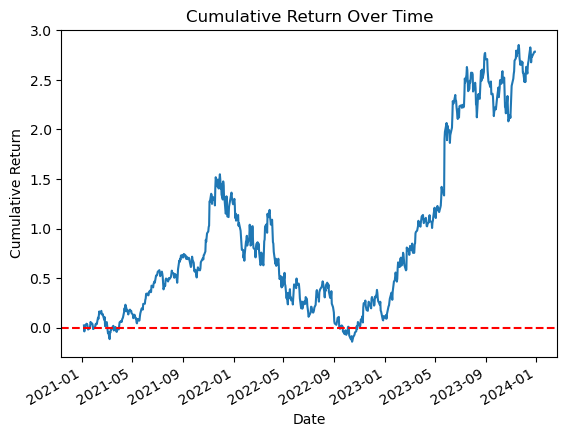

Cumulative Return on 2023-12-29 is 278.52%


In [2555]:
# plot the cumulative return
df['Cumulative Return'].plot()
plt.title('Cumulative Return Over Time') # add title
plt.ylabel('Cumulative Return') # add y axis label

# plot a horizontal line on y = 0
plt.axhline(y=0.0, color='red', linestyle='--')

plt.show()

# print cumulative return at the end of the time period
print(f'Cumulative Return on {df.index[-1].date()} is {round(df["Cumulative Return"][-1] * 100, 2)}%')

If an investor bought NVDA stock in the beginning of 2021, they would receive an impressive 279% return over the span of 3-year period. For comparison, the S&P500's cumulative return over the same time span was only around 28%, highlighting NVDA's impressive outperformance.

Moreover, throughout the period, the cumulative return remained positive most of the time. The stock was intially able to reach the 150% level in December 2021. However it swiftly dropped to its the lowest point in October 2022. But then short after, the stock quickly recovered, surging to a cumulative return of 279% in just over a year.

**Normality Test on the NVDA Returns**

We are going to visually test for normality of NVDA's daily returns. Let's start with a histogram,

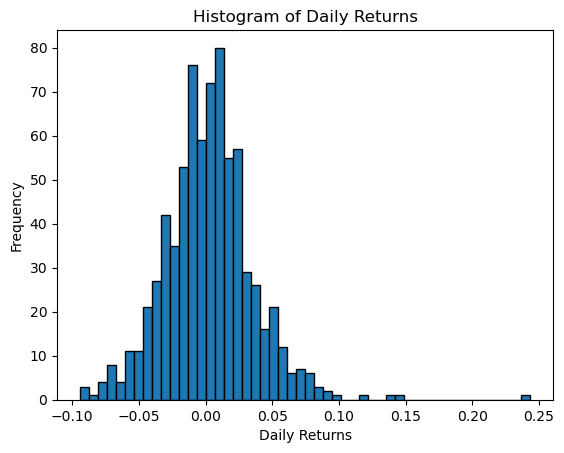

In [2559]:
# plot histogram
plt.hist(df['Daily Return'], bins=50, edgecolor='black')
plt.title('Histogram of Daily Returns') # add title
plt.xlabel('Daily Returns') # add x axis label
plt.ylabel('Frequency') # add y axis label
plt.show()

The histogram shows that the distribution of daily returns are fairly bell-shaped. However, we do notice that it has a fat tail on the right side of the distribution.

To properly test for nomality, we are going to use the Shapiro-Wilk Test to test for normallity. The hypotheses are,
>H_0: The undelying population is normally distributed.

>H_1: The underlying population is NOT normally distributed.

In [2562]:
# Shapiro-Wilk test
stat, p_val = sp.stats.shapiro(df['Daily Return'])

# decision making: 0.05 significance level (alpha)
alpha = 0.05
if p_val > alpha:
    print(f'Since p-value ({p_val}) > {alpha}, we fail to reject the null hypothesis.')
else:
    print(f'Since p-value ({p_val}) < {alpha}, we reject the null hypothesis.')

Since p-value (1.0) > 0.05, we fail to reject the null hypothesis.


From the Shapiro-Wilk test, we can conclude that the Daily Return is normally distributed.

**The Top 10 Largest Daily Returns and Top 10 Smallest Daily Returns**

In [2566]:
# plot bar chart
def plot_bar(x, y, title, xlabel, ylabel, x_rotation):
    # create bar chart
    plt.bar(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=x_rotation) # rotate the x axis label
    plt.show()

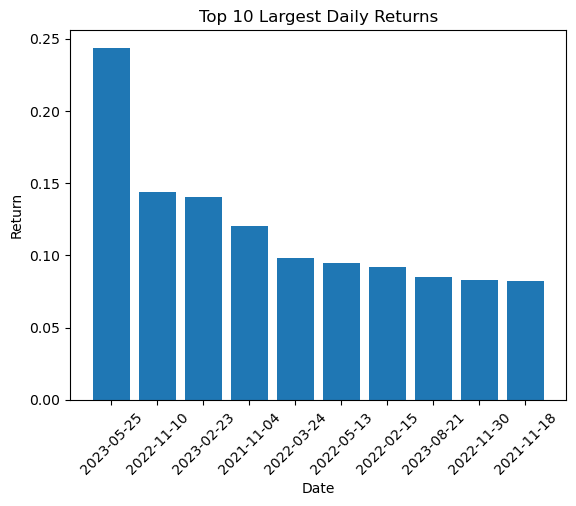

In [2568]:
# Sort the data to get the top 10 largest returns
top_10_largest = df[['Daily Return']].sort_values(by='Daily Return', ascending=False).head(10)

# Plotting the top 10 largest returns
plot_bar(top_10_largest.index.strftime('%Y-%m-%d'),
         top_10_largest['Daily Return'],
         'Top 10 Largest Daily Returns',
         'Date',
         'Return',
         45)

The bar chart shows that the largest daily return was on May 25, 2023 at around 24%. It is almost twice as large as the send largest daily return. The reason for this large return was due to Nvidia's earnings was able to greatly beat analysts' estimates.

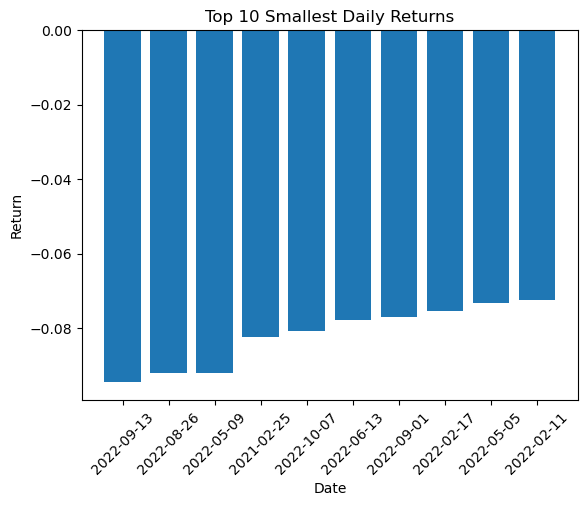

In [2571]:
# Sort the data to get the top 10 largest returns
top_10_smallest = df[['Daily Return']].sort_values(by='Daily Return', ascending=True).head(10)

# Plotting the top 10 largest returns
plot_bar(top_10_smallest.index.strftime('%Y-%m-%d'),
         top_10_smallest['Daily Return'],
         'Top 10 Smallest Daily Returns',
         'Date',
         'Return',
         45)

The top 10 smallest daily return figures are more tighly packed together. The largest drop happened on September 13, 2022 at around -9.5%. While the second and third largest drop were closer to the -9.0% level.

**Average Traded Volume on Dividend Payment Date**

We are now going to compare the average daily volume between when dividends are paid and when they are not.

Dividend Paid
False    4.588532e+08
True     4.446749e+08
Name: Volume, dtype: float64


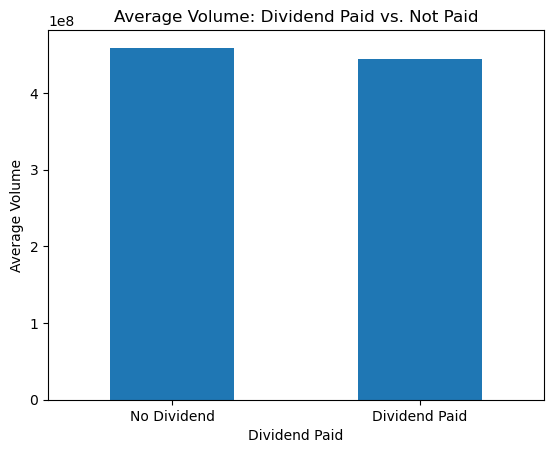

In [2575]:
# Group by 'Dividend Paid' column and compute mean
avg_volume = df.groupby('Dividend Paid')['Volume'].mean()
print(avg_volume)

# plot the average volumes
avg_volume.plot(kind='bar')
plt.title('Average Volume: Dividend Paid vs. Not Paid')
plt.xlabel('Dividend Paid')
plt.ylabel('Average Volume')
plt.xticks(ticks=[0, 1], labels=['No Dividend', 'Dividend Paid'], rotation=0)
plt.show()

We observe that the trading volume is lower on days when dividends are paid compared to days when no dividend is paid. This could be attributed to the fact that macroeconomic events, company-specific news, and other market events are more of a needle mover. As dividend payments are typically anticipated (i.e. it does not provide immediate new information), they may not generate the same level of market activity.

**Upticks and Downticks**

We are going to count the number of upticks (positive returns) and downticks (negative returns). 

In [2579]:
# count the number of positive and negative returns
n_upticks = (df['Daily Return'] > 0).sum()
n_downticks = (df['Daily Return'] < 0).sum()

In [2581]:
# copmute the percentage of upticks and downticks
total = n_upticks + n_downticks
uptick_pct = (n_upticks / total) * 100
downtick_pct = (n_downticks / total) * 100

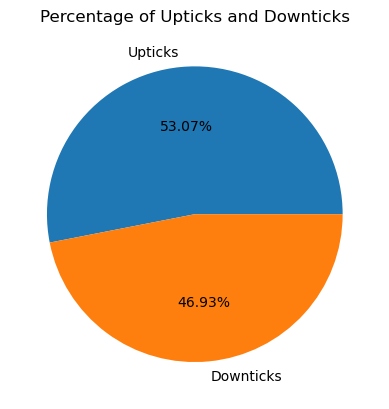

In [2583]:
# plot the pie chart
plt.pie([uptick_pct, downtick_pct], labels=['Upticks', 'Downticks'], autopct='%1.2f%%')
plt.title('Percentage of Upticks and Downticks')
plt.show()

There are 6.2% more upticks and downticks. This tendency of the stock price to go up contributes to NVDA's remarkable performance over the time period.

**High-Low Range vs Volume**

We are going to analyze the relationship between the High-Low Range and Volume. To do so, we will create a scatter plot and compute the correlation coefficient.

In [2587]:
# a function to create scatter plot and compute correlation coef
def plot_scatter_corr(df, x, y, title, xlabel, ylabel):
    # create scatter plot
    sns.scatterplot(x, y, data=df)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    # compute and print correlation coef
    correlation = df[[x, y]].corr()
    display(correlation)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


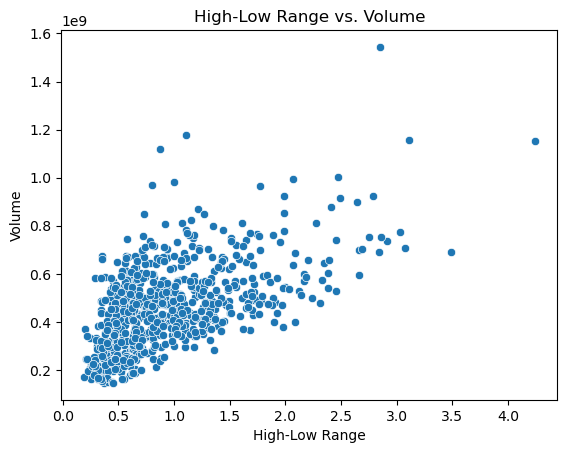

,High-Low Range,Volume
High-Low Range,1.00000,0.58012
Volume,0.58012,1.00000


In [2589]:
# create scatter plot and corr coef
plot_scatter_corr(df, 'High-Low Range', 'Volume', 'High-Low Range vs. Volume', 'High-Low Range', 'Volume')

We observe a positive correlation between volume and high-low range, with correlation coefficient of 0.58. In other words, When a stock experiences a large intraday volatility, it is often accompanied by increased trading volume. This observation makes logical sense because in order to greatly move the price up/down, a large number of shares would need to be traded.

Let's dive deeper in analyzing this correlation by specifically focusing on 'extreme' events, i.e. when the Daily Return is in the top or bottom 10%.

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


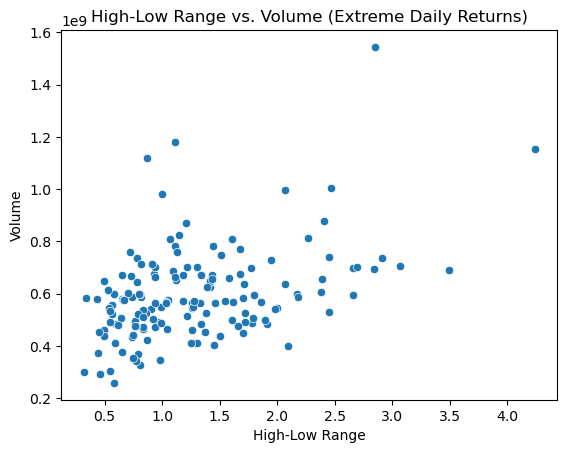

,High-Low Range,Volume
High-Low Range,1.000000,0.438862
Volume,0.438862,1.000000


In [2593]:
# create scatter plot and corr coef
df_ext = df[(df['Daily Return'] > df['Daily Return'].quantile(0.90)) | (df['Daily Return'] < df['Daily Return'].quantile(0.10))]
plot_scatter_corr(df_ext, 'High-Low Range', 'Volume', 'High-Low Range vs. Volume (Extreme Daily Returns)', 'High-Low Range', 'Volume')

We observe a similar trend when focsuing on both the entire dataset and the extreme value case. But interestingly, the correlation coefficient for the extreme value case is 0.44, which is lower than that for the entire dataset. This suggests a weaker positive relationship.

**High-Low Range vs Intraday Return**

We are going to investigate the relationship between high-low range and the magnitude of intraday return. Just like before, we are going to compute a scatter plot and correlation coefficient.

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


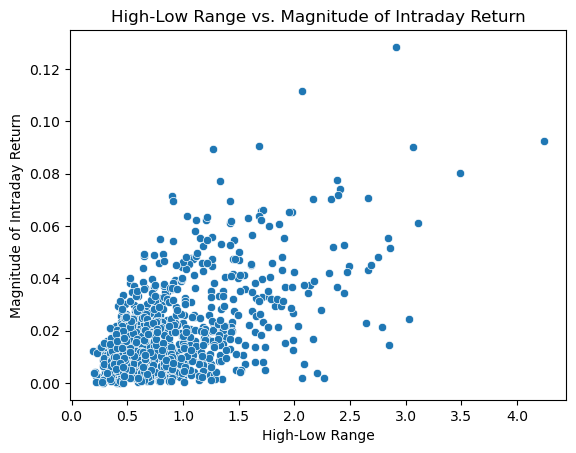

,High-Low Range,Magnitude of Intraday Return
High-Low Range,1.000000,0.549009
Magnitude of Intraday Return,0.549009,1.000000


In [2597]:
# compute the magnitude of Intraday Return (absolute value)
df['Magnitude of Intraday Return'] = df['Intraday Return'].abs()

# create scatter plot and corr coef
plot_scatter_corr(df, 'High-Low Range', 'Magnitude of Intraday Return', 'High-Low Range vs. Magnitude of Intraday Return', 'High-Low Range', 'Magnitude of Intraday Return')

We observe a positive correlation between the High-Low Range and the magnitude of the Intraday Return, with a correlation coefficient of 0.55. The scatter plot also shows a clear positive trend. This observation is similar to what I initially expected. As larger intraday returns (in magnitude) typically correspond to larger High-Low Ranges; while days with smaller intraday returns (in magnitude) can be accompanied by either large or small High-Low Ranges.

### Weekday Level
In Weekday level of analysis, the dataset is going to be grouped by the day of the week to explore any potential patterns across different weekdays.

**Averege Returns**

We are going to group the dataset by the Weekday, and then compute the average daily return.

In [2602]:
# compute the average return grouped by the specified column
def compute_average_return_by_group(df, group_by_column):
    # group by the 'group_by_column' and compute the avg of 'Daily Return'
    avg_returns = df.groupby(group_by_column)['Daily Return'].mean().reset_index()
    # rename the column
    avg_returns.rename(columns={'Daily Return': 'Average Return'}, inplace=True)
    # sort by average return
    avg_returns.sort_values(by='Average Return', ascending=False, inplace=True)
    return avg_returns

,Weekday,Average Return
2,Thursday,0.006395
1,Monday,0.003717
3,Tuesday,0.002255
4,Wednesday,0.000251
0,Friday,-0.000841


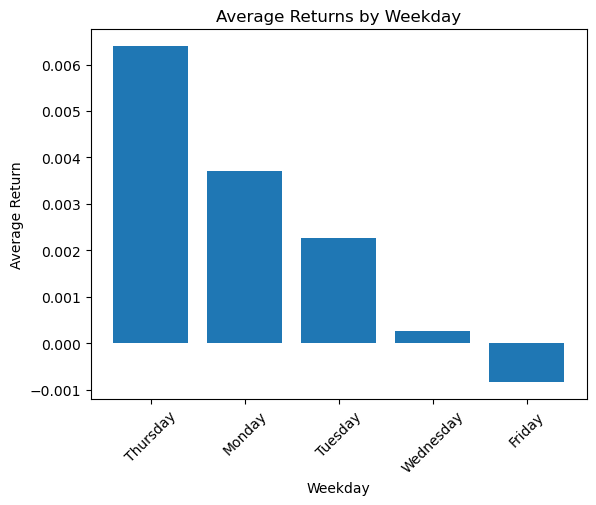

In [2604]:
# compute average returns grouped by weekdays
average_returns_by_weekday = compute_average_return_by_group(df, 'Weekday')
display(average_returns_by_weekday)

# plot bar chart
plot_bar(average_returns_by_weekday['Weekday'],
         average_returns_by_weekday['Average Return'],
         'Average Returns by Weekday', 'Weekday', 'Average Return', 45)

There were significant differences in the average returns across weekdays. I had expected the average returns between the groups to be similar, but it turned out that Thursdays historically yielded the highest average return of 0.64%. On the other hand, Fridays appeared to be a less favorable day for holding a long position, as they showed an average return of -0.08%.

**Total Volumes**

We are going to group the dataset by the Weekday, and then compute the total volumes.

In [2608]:
# compute the total traded volume grouped by the specified column
def compute_total_volume_by_group(df, group_by_column):
    # group by the 'group_by_column' and compute the avg of 'Daily Return'
    total_volumes = df.groupby(group_by_column)['Volume'].sum().reset_index()
    # rename the column
    total_volumes.rename(columns={'Volume': 'Total Volume'}, inplace=True)
    # sort by the total volume
    total_volumes.sort_values(by='Total Volume', ascending=False, inplace=True)
    return total_volumes

,Weekday,Total Volume
2,Thursday,74567357000
4,Wednesday,71033310000
0,Friday,69985692000
3,Tuesday,68864430000
1,Monday,60881367000


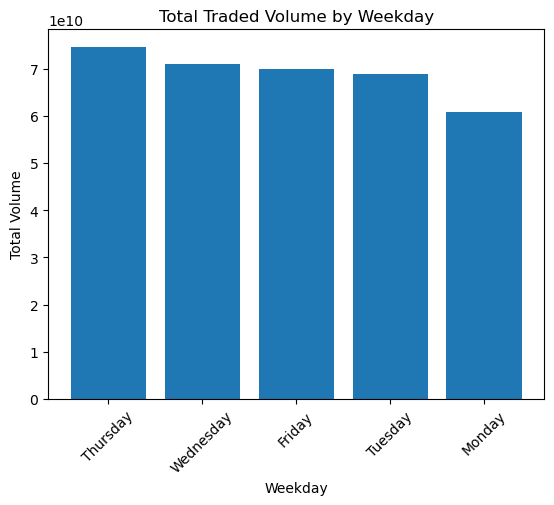

In [2610]:
# compute total volumes grouped by weekdays
total_volume_by_weekday = compute_total_volume_by_group(df, 'Weekday')
display(total_volume_by_weekday)

# plot bar chart
plot_bar(total_volume_by_weekday['Weekday'],
         total_volume_by_weekday['Total Volume'],
         'Total Traded Volume by Weekday', 'Weekday', 'Total Volume', 45)

We observed that Thursday had the highest total traded volume, exceeding 74 billion shares over the 3-year period. Wednesday and Friday followed closely, with 71 billion and 70 billion shares, respectively. In contrast, Monday recorded the lowest total traded volume, with only 60 billion shares.

Combining this insight with the analysis of the Average Return chart from earlier, we noted that the large average return on Thursday was accompanied by high trading volume. This observation suggests a potential positive correlation between trading volume and market activity on Thursdays.

**Annualized Standard Deviation of Daily Return**

We are going to group the dataset by the Weekday, and then compute the annualized standard deciation of the daily return.

In [2614]:
# compute the annualized standard deviation of returns grouped by the specified column
def compute_annualized_std_by_group(df, group_by_column):
    # group by the specified column and compute the std of 'Daily Return'
    std_dev = df.groupby(group_by_column)['Daily Return'].std()
    # annualize the standard deviation
    annualized_std = std_dev * (252 ** 0.5)
    # reset the index for readability
    annualized_std = annualized_std.reset_index()
    # rename the column
    annualized_std.rename(columns={'Daily Return': 'Annualized Std'}, inplace=True)
    # sort by teh Annualized Std
    annualized_std.sort_values(by='Annualized Std', ascending=False, inplace=True)
    return annualized_std

,Weekday,Annualized Std
2,Thursday,0.680024
1,Monday,0.505257
4,Wednesday,0.487184
0,Friday,0.477784
3,Tuesday,0.468125


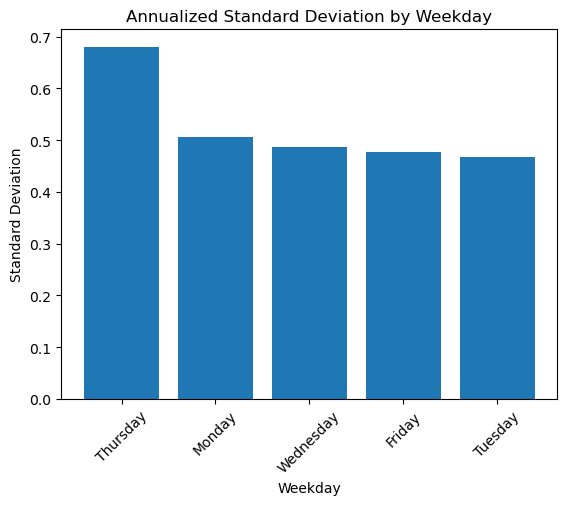

In [2616]:
# Compute annualized standard deviation grouped by weekdays
annualized_std_by_weekday = compute_annualized_std_by_group(df, 'Weekday')
display(annualized_std_by_weekday)

# plot bar chart
plot_bar(annualized_std_by_weekday['Weekday'],
         annualized_std_by_weekday['Annualized Std'],
         'Annualized Standard Deviation by Weekday', 'Weekday', 'Standard Deviation', 45)

Based on our previous analysis, Thursday had the highest average return and total volume. It is, therefore, not surprising to see that Thursday also had the largest annualized standard deviation at 0.68, indicating very high volatility. Moreover, the gap between Thursday and the other weekdays was quite significant. For example, Monday, which had the second-highest annualized standard deviation, showed a difference of approximately 0.20.

### Month Level
We are moving on to grouping by Month to check for any patterns across different months.

**Averege Returns**

We are going to group the dataset by the Month, and then compute the average daily return.

,Month,Average Return
2,11,0.010337
7,5,0.007317
4,2,0.004718
9,7,0.004503
5,3,0.004423
1,10,0.004356
0,1,0.002260
8,6,0.002181
10,8,0.000607
3,12,-0.002591


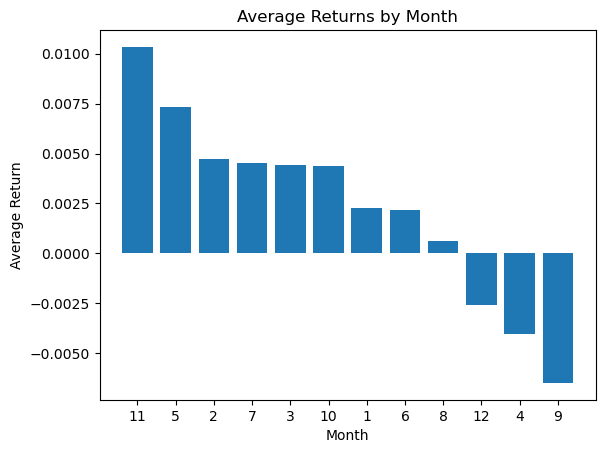

In [2621]:
# Compute average returns grouped by month
average_returns_by_month = compute_average_return_by_group(df, 'Month')
display(average_returns_by_month)

# plot bar chart
plot_bar(average_returns_by_month['Month'],
         average_returns_by_month['Average Return'],
         'Average Returns by Month', 'Month', 'Average Return', 0)

From the chart above, we can see that November and May stood out as the most profitable months, with average daily returns of 1.0% and 0.7%, respectively. Furthermore, the months of February, July, March, and October showed very similar performances, each with an average return of around 0.45%. In contrast, September was the least profitable month, with an average daily return of -0.65%. It is worth noting that, with a larger dataset, the average daily returns for each month would likely become more similar.

**Total Volumes**

We are going to group the dataset by the Month, and then compute the total volumes.

,Month,Total Volume
7,5,32585220000
10,8,32118186000
8,6,31355133000
5,3,30556986000
2,11,30556391000
4,2,27718073000
1,10,27661456000
3,12,27416544000
9,7,27094398000
11,9,26708837000


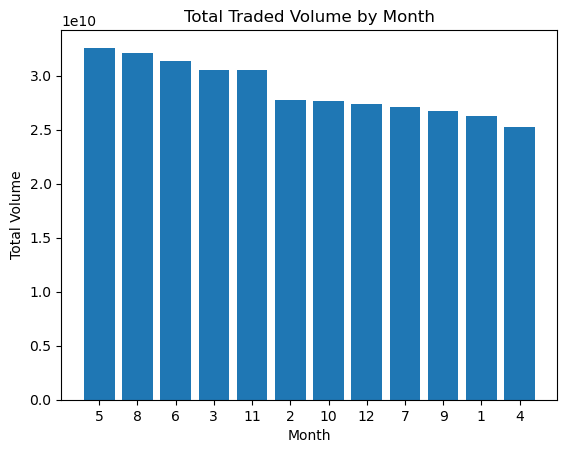

In [2625]:
# compute total volumes grouped by moenth
total_volume_by_month = compute_total_volume_by_group(df, 'Month')
display(total_volume_by_month)

# plot bar chart
plot_bar(total_volume_by_month['Month'],
         total_volume_by_month['Total Volume'],
         'Total Traded Volume by Month', 'Month', 'Total Volume', 0)

The total traded volume was led by the month of May with 32.6 billion shares, and closely followed by August with 32.1 billion shares. On the other hand, April recorded the lowest total traded volume at just 25.3 billion shares.

By combining analysis from the previous chart, I have noticed an interesting observation. The total traded volume in September was relatively small compared to the other months, eventhough September generated a large magnitude of return, in which we would expect a high market activity. This contrasts with May, where the large return magnitudes were accompanied by high market activity. This pattern may suggest a potential positive correlation between daily returns and traded volume.

**Annualized Standard Deviation of Daily Return**

We are going to group the dataset by the Month, and then compute the annualized standard deciation of the daily return.

,Month,Annualized Std
7,5,0.740653
4,2,0.647195
2,11,0.574138
5,3,0.543527
0,1,0.539568
3,12,0.505561
10,8,0.496347
6,4,0.482955
8,6,0.474419
1,10,0.463880


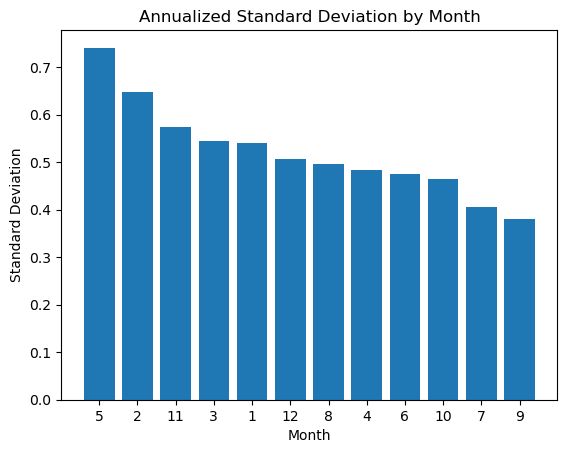

In [2629]:
# Compute annualized standard deviation grouped by month
annualized_std_by_month = compute_annualized_std_by_group(df, 'Month')
display(annualized_std_by_month)

# plot bar chart
plot_bar(annualized_std_by_month['Month'],
         annualized_std_by_month['Annualized Std'],
         'Annualized Standard Deviation by Month', 'Month', 'Standard Deviation', 0)

As expected, the month of May and November had a high standard deviations at 0.741 and 0.574, respectively, since in those months, we observe a high market activity and average daily return. Moreover, we notice that September had a relatively low volatility with annualized standard deviation of only 0.38, eventhough in the same month, we observe a large average negative return.

## 4. Ask Questions About The Data

### Question 1

**Introduction of MA Crossover**

One of the most widely used methods in technical analysis is the Moving Average Crossover strategy. This strategy involves the use of two moving averages: a short-term moving average (MA) and a longer-term moving average. The rule is simple:
- A buy signal is generated when the shorter-term MA crosses above the longer-term MA.
- A sell signal is generated when the shorter-term MA crosses below the longer-term MA.

**Scope / Question**

For this analysis, we will employ a long-only moving average crossover strategy. This means,
- We will only act on the buy signals generated when the shorter-term MA crosses above the longer-term MA.
- When acting on a buy signal, we will purchase 1 unit of stock and hold it for a specified period (referred to as the holding period).
- After the holding period ends, we will sell the stock and record the returns.

The goal of this analysis is to answer the question,
>*"When applying a moving average crossover strategy on NVDA stock, which combination of short-term MA, long-term MA, and holding period produces the highest return?"*

To address this question, we will test three combinations of short-term, medium-term, and long-term configurations. Each combination has its own unique combination of short-term MA, long-term MA, and holding period:
- Short-term Configuration:
    - Short-term MA = 3 days
    - Long-term MA = 10 days
    - Holding period = 5 days
- Medium-term Configuration:
    - Short-term MA = 5 days
    - Long-term MA = 20 days
    - Holding period = 10 days
- Long-term Configuration:
    - Short-term MA = 10 days
    - Long-term MA = 40 days
    - Holding period = 20 days

**Expectation**

We expect that the shorter-term configuration will trump over the longer-term configuration because shorter-term configuration is more responsive to price changes in the market, thus it will be able to capitalize on more trading opportunities.

In [2635]:
def ma_crossover(df, short_window=10, long_window=20, holding_period=10):
    # calculate the short-term and long-term MAs
    df['Short Term MA'] = df['Close'].rolling(window=short_window).mean()
    df['Long Term MA'] = df['Close'].rolling(window=long_window).mean()
    
    # create indicator column
        # 0 represents when Short Term MA < Long Term MA
        # 1 represents when Short Term MA > Long Term MA
    df['Indicator'] = 0 
    df['Indicator'] = np.where(df['Short Term MA'] > df['Long Term MA'], 1, 0)
    
    # generate buy and sell signals (i.e. detects crossovers)
    df['Signal'] = df['Indicator'].diff()
    buy_signals = df[df['Signal'] == 1]  # buy signal -> when Short Term MA crosses above Long Term MA
    
    # compute the returns by holding for the next 'holding_period' trading days (i.e. 'holding_period' number of rows)
    returns = []
    cum_ret = 1
    win_count = 0
    for date, row in buy_signals.iterrows():
        entry_date = date
        # ensure there are enough rows after buy signal is generated
        if (df.index.get_loc(entry_date) + holding_period) < len(df):
            # set exit date
            exit_date = df.index[df.index.get_loc(entry_date) + holding_period]
            
            # store the entry and exit price
            entry_price = df.loc[entry_date, 'Close']
            exit_price = df.loc[exit_date, 'Close']
            
            # compute return
            ret = (exit_price - entry_price) / entry_price
            
            # store the return
            returns.append(ret)
            
            # update the cum ret
            cum_ret *= (1 + ret)
            
            # update win_count if trade is profitable
            if ret > 0:
                win_count += 1
    
    # Calculate performance metrics
    avg_return = np.mean(returns) # average return
    vol = np.std(returns) # volatility of returns
    num_trades = len(returns) # numer of trades
    win_rate = (win_count / num_trades) # win rate
    cum_ret = (cum_ret - 1) # cumulative return
    
    # store performance summary metrics in a dictionary
    perf_sum = {'short_window/long_window/holding_period': f'{short_window}/{long_window}/{holding_period}',
                'Average Return': avg_return,
                'Cumulative Return': cum_ret,
                'Volatility of Returns': vol,
                'Win Rate': win_rate,
                'Number of Trades': num_trades
                }
    
    # Plot the moving averages
    plt.figure(figsize=(14, 7))
    plt.plot(df['Close'], label='Close Price', color='blue', alpha=0.6)
    plt.plot(df['Short Term MA'], label=f'{short_window}-Day MA', color='green')
    plt.plot(df['Long Term MA'], label=f'{long_window}-Day MA', color='red')
    
    # Plot entry points
    plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy')
    
    plt.title(f"Moving Average Crossover Strategy ({short_window}-Day vs {long_window}-Day MA)")
    plt.legend()
    plt.show()
    
    # perforamnce summary
    return perf_sum

Parameters: Short-term=10, Long-term=40, Holding period=20


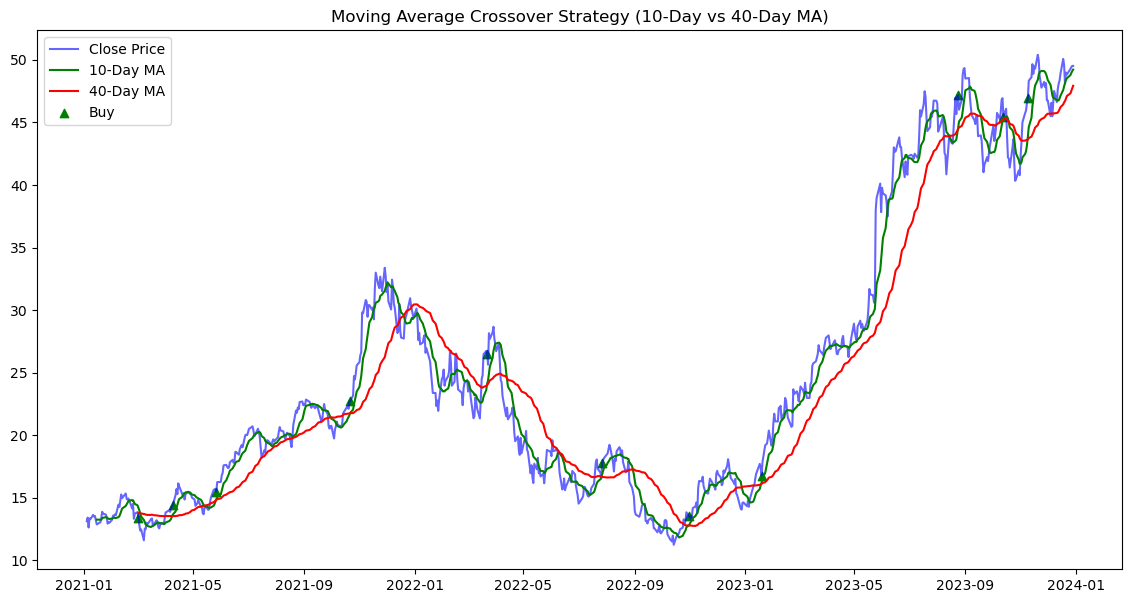

Parameters: Short-term=5, Long-term=20, Holding period=10


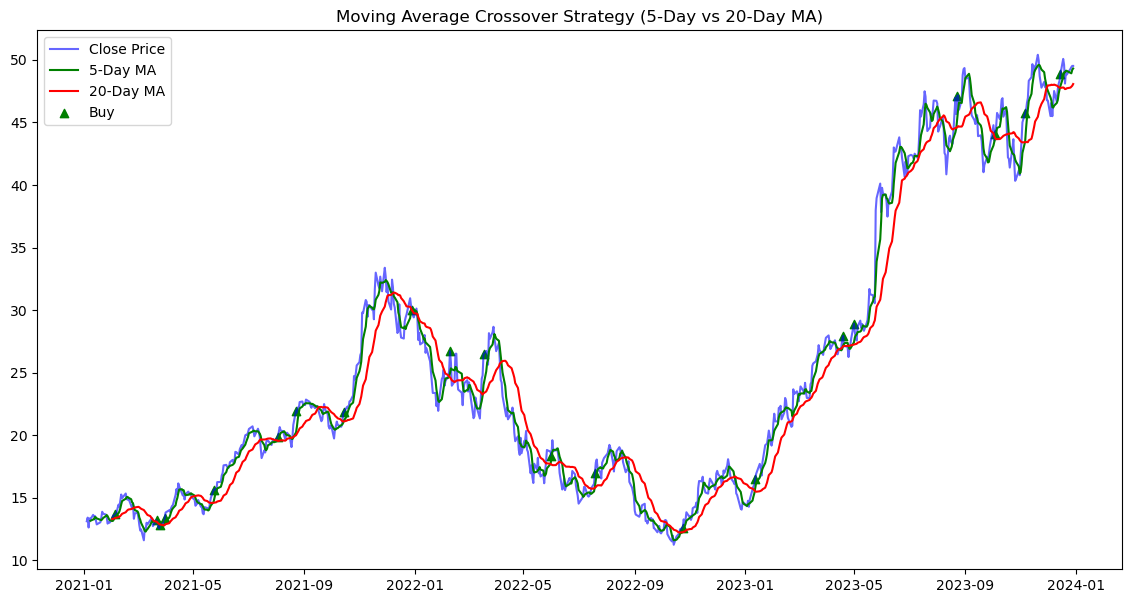

Parameters: Short-term=3, Long-term=10, Holding period=5


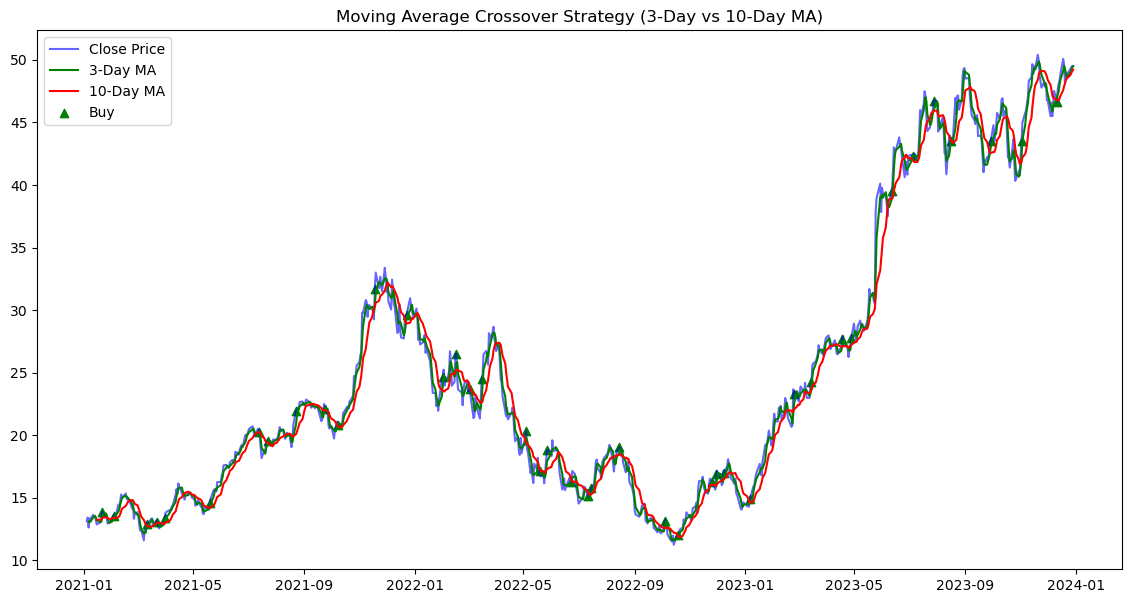


Summary of Performance Metrics:


,short_window/long_window/holding_period,Average Return,Cumulative Return,Volatility of Returns,Win Rate,Number of Trades
1,5/20/10,0.053557,1.599820,0.098839,0.650000,20
0,10/40/20,0.079507,0.991787,0.182625,0.636364,11
2,3/10/5,0.009378,0.323011,0.070333,0.536585,41


In [2637]:
df_ma = df.copy()

# Define the parameter combinations
parameter_combinations = [{'short_window': 10, 'long_window': 40, 'holding_period': 20},
                          {'short_window': 5, 'long_window': 20, 'holding_period': 10},
                          {'short_window': 3, 'long_window': 10, 'holding_period': 5}]

# Store results
results = []

# Perform analysis for each parameter combination
for params in parameter_combinations:
    print(f"Parameters: Short-term={params['short_window']}, Long-term={params['long_window']}, Holding period={params['holding_period']}")
    performance = ma_crossover(
        df_ma, 
        short_window=params['short_window'], 
        long_window=params['long_window'], 
        holding_period=params['holding_period']
    )
    results.append(performance)

# Display results in a DataFrame for better readability
results_df = pd.DataFrame(results)

# Sort results by Cumulative Return (descending) for comparison
results_df = results_df.sort_values(by='Cumulative Return', ascending=False)

print("\nSummary of Performance Metrics:")
display(results_df)

In the time series chart 'Moving Average Crossover Strategy (3-Day vs 10-Day MA)' (which represents the Short-term Configuration), we see that the moving averages are very sensitive to price changes. This results in many MA crossovers, and thus it generates the most buy signals (compared to the other two configurations). While being reactive to market price changes may seem advantageous, the short-term configuration suffers from significant drawbacks. As we can see, the win rate of the Short-term configuration is the lowest at 53.66%. Additionally, the average return per trade is just 0.94%, which reflects the limitations of a short holding period of 5 days, leaving little room to capitalize on meaningful price trends. Consequently, the cumulative return of the short-term configuration is only 32.23%, the poorest performance of the three configurations. Moreover, we can also see that the volatility of returns per trade is relatively high when compared to its average return, making this configuration less desirable/riskier. Despite its underperformance, the strategy might benefit from extending the holding period.

Moving on to the Long-term configuration, we can observe the 'Moving Average Crossover Strategy (10-Day vs 40-Day MA)' chart that the moving averages are much less resposnive to the price changes. This means that an MA crossovers can only happen when the trend presists for a significant period of time. This means that it is great at capitalizing on long-term trends. However, it also means that it will only make a few number of trades (in this case only 11 trades were made). Given that the stock price was able to show persistent trend, it greatly benefits the performance of the long-term configuration. For example, we observe a consistent uptrend in 2021 and in the first half of 2023. This leads to an impressive 63.63% win rate and a cumulative return of 99.18%. However, the configuration’s reliance on long-term trends may lead to underperformance in sideways or choppy market conditions.

Finally, we are going to look at the medium term configuration, which is the best performer, with cumulative return of 159.98% also having the largest win rate of 65.00%. The reason is because the medium term configuration benefits from the fact that it is responsive to price cahnges, but at the same time not too responsive which leads to false signal (i.e. negative returns). Moreover, it also has a long enough holding period, such that it can gain a good profit from persisting trend in the market, as shown the table where it has an average return of 5.56% per trade. Moreover, the volatility of returns is relatively low compared to the average return, making this strategy more attractive from a risk-adjusted perspective.

Thus, contrary to initial expectations, the analysis reveals that a balanced approach (i.e. the medium-term configuration) is more effective than purely focusing on high responsiveness. The medium-term configuration achieves the best performance by striking a balance between responsiveness and holding period. This balance enables it to capitalize on sustained trends while avoiding false signals.

### Question 2

**Introduction to Monday Effect**

The Monday Effect is a phenomenon in financial markets where the trend of stock returns on Friday will prevail into Monday (i.e. the next trading day). In other words, if the stock generates a positive return on a Friday, the momentun will be carried over to Monday (i.e. Monday will have a positive return as well). Similarly, if Friday's return is negative, then the return on Monday will likely be negative as well.

**Scope / Question**

Firstly, we are going to test whether the Monday effect is observable on NVDA stock.

>*"Do we observe Monday effect on NVDA stock?"*

Then we are going to extend the analysis for other consecutive days, such as Monday-Tuesday, Tuesday-Wednesday, etc.

>"*Are there any other consecutive days where we would observe a similar effect?*"

Lastly, we will see if this effect is observable during extreme market events (i.e. magnitude of Daily returns that are in the top 10%),

>"How does the Monday effect get impacted during extreme market events?"

In [2639]:
# a function to compute the correlation between 2 consecutive trading days
def monday_effect(df_consec, extreme=False):
    # create a copy of data frame
    df_consec = df.copy()

    # ensure that the table is sorted in ascending order
    df_consec = df_consec.sort_index(ascending=True)

    # create the lagged daily return by 1 shift
    df_consec['Prev Daily Return'] = df_consec['Daily Return'].shift(1)

    # create pairs of consecutive weekdays
    day_pairs = ['Friday-Monday', 'Monday-Tuesday', 'Tuesday-Wednesday', 'Wednesday-Thursday', 'Thursday-Friday']

    # create a new column for the name of consecutive trading days
    df_consec['Day Pair'] = df_consec['Weekday'].shift(1) + '-' + df_consec['Weekday']

    # extreme case analysis 
    if extreme:
        # drop empty row to prevent error when computing percentile
        daily_ret_dropped = df_consec['Daily Return'].dropna().abs()
        # compute the threshold for the top 10% daily return magnitude
        threshold = np.percentile(daily_ret_dropped, 90)
        # filter to only keep extreme market events
        df_consec = df_consec[df_consec['Daily Return'].abs() >= threshold]
    
    # filter to only keep valid day pairs
    df_consec = df_consec[df_consec['Day Pair'].isin(day_pairs)].dropna(subset=['Prev Daily Return', 'Daily Return'])
    
    # compute the average return
    stats = df_consec.groupby('Day Pair')[['Prev Daily Return', 'Daily Return']].mean()

    # # compute correlation
    # corr_3d_table = df_consec.groupby('Day Pair')[['Prev Daily Return', 'Daily Return']].corr()

    corr_dict = {} # store correlation in dictionary
    p_value_dict = {} # store p-value
    for pair in day_pairs:
        # filter the pairs
        pair_data = df_consec[df_consec['Day Pair'] == pair]

        # compute Spearman's Rank Correlation
        corr, p_value = sp.stats.spearmanr(pair_data['Prev Daily Return'], pair_data['Daily Return'])

        # store in dictionary
        corr_dict[pair] = corr
        p_value_dict[pair] = p_value

    # Adding the corr and p-value dictionary into the stats table
    stats['Spearman Correlation'] = stats.index.map(corr_dict)
    stats['P-Value'] = stats.index.map(p_value_dict)
    
    return stats

**Do we observe Monday effect on NVDA stock?**

In [2642]:
# create a copy of data frame
df_consec = df.copy()

# test for monday effect
result = monday_effect(df_consec, extreme=False)
result.loc[['Friday-Monday'],:]

,Prev Daily Return,Daily Return,Spearman Correlation,P-Value
Day Pair,,,,
Friday-Monday,-0.001105,0.003055,0.11658,0.183119


From the table above, it shows that Friday's and Monday's returns have a very weak positive correlation (+0.12). In other words, the Friday's return is not a strong predictor for Monday's return. Moreover, assuming use the significance level (alpha) = 0.05, we see that the p-value (0.18) is greater than 0.05, thus we fail to reject the null (i.e. no statistically significant correlation). Thus, it is not a surpise to see that the average daily return on Friday and Monday are of opposite sign, -0.11% and +0.31%, respectively.

Side note: we use Spearman's correlation because it is less sensitive to outliers.

**Are there any other consecutive days where we would observe a similar effect?**

In [2646]:
# create a copy of data frame
df_consec = df.copy()

# test for monday effect
result = monday_effect(df_consec, extreme=False)
result

,Prev Daily Return,Daily Return,Spearman Correlation,P-Value
Day Pair,,,,
Friday-Monday,-0.001105,0.003055,0.116580,0.183119
Monday-Tuesday,0.003725,0.002182,-0.047064,0.587787
Thursday-Friday,0.006528,-0.000390,0.059706,0.469486
Tuesday-Wednesday,0.002255,0.000268,0.000081,0.999206
Wednesday-Thursday,0.000029,0.006395,-0.041394,0.611433


We observe a weak and inconsistent relationships on the pairs. The correlation coefficients are generally close to zero across all day pairs, which indicates the lack of dependency of the return of one day and the next. For example, Monday-Tuesday (-0.047), Thursday-Friday (0.060), and Wednesday-Thursday (-0.041) all display negligible correlations with high p-values which reinforcing the lack of significance.

Lastly, I want to point out that the Tuesday-Wednesday pair has a near-zero correlation (0.00008) and the highest p-value (0.999), indicating no meaningful relationship between the returns of these days.

Overall, this result suggests that there is no / lack of evidence to support the dependencies across consecutive trading days.

**How does the Monday effect get impacted during extreme market events?**

In [2650]:
# create a copy of data frame
df_consec = df.copy()

# test for monday effect on extreme events
result = monday_effect(df_consec, extreme=True)
result

,Prev Daily Return,Daily Return,Spearman Correlation,P-Value
Day Pair,,,,
Friday-Monday,-0.007447,0.008833,0.257353,0.318668
Monday-Tuesday,-0.002156,0.039438,-0.533333,0.139227
Thursday-Friday,0.007465,-0.003170,-0.328671,0.296904
Tuesday-Wednesday,0.008575,0.010202,-0.264286,0.341174
Wednesday-Thursday,-0.004907,0.029577,-0.419537,0.051932


Observing the result from extreme market events (defined as daily returns in the top 10% by magnitude), we see a more interesting insights about the relationship between returns on consecutive trading days. The correlation between the previous day’s return and the current day’s return for different pairs show mixed patterns. Starting off with the Monday effect (i.e. the Friday-Monday pair), we observe a correlation of 0.26, which again is a weak postive correlation. In contrast, observing of the Monday-Tuesday and Wednesday-Thursday pair, they are moderately negative correlated with correlation coef. of -0.53 and -0.42, respectively. Furthermore, notice that since these two pairs have quite a strong negative correlation, the average of yesterday's and today's daily returns are of opposite sign, -0.22% and +0.31% for Monday-Tuesday paid and -0.49% and 2.96% for Wednesday-Thursday pair.

However, none of the correlations are statistically significant at alpha=0.05, all of the p-values are greater than 0.05. It is worth to point out that Wednesday-Thursday pair has the lowest p-value (0.052), indicating a potential negative correlation (-0.420) that is nearly significant at the 5% level.

In short, the lack of significant correlations across all of the pairs suggests that extreme market events do not exhibit strong patterns of return between consecutive days.

### Question 3

**Introduction**

In this analysis, we explore the potential predictive power of lagged returns and volatility indicators using linear regression. The goal is to identify whether past returns and market volatility can serve as reliable predictors for future price movements.

**Scope / Question**

We begin by performing a simple linear regression using t-1 Return (previous day's return) as the sole feature to predict the current day's return. The aim is to determine whether a clear linear relationship exists, which would suggest that the previous day’s return could be a reliable predictor of stock price movement.
> "*Does the previous day's return (t-1 Return) provide a reliable linear relationship for predicting the current day's return?*"

Next, we will be examining the performance of linear regression model using different sets of lagged daily returns as the features. We will be testing multiple configurations, including t-1 Return (previous day’s return), t-1 and t-2 Returns (previous two days' returns), and so on, up to t-1, t-2, t-3, t-4, and t-5 Returns. The performance measure that will be used is the Mean-Squared-Error (MSE) to evaluate the accuracy of the prediction. This analysis will help us to determine which configuration of lagged returns performs best.
> "*How does the inclusion of additional lagged returns (up to t-5) affect the predictive accuracy of a linear regression model for daily stock returns?*"

Then finally, out of the different configurations of lagged returns, we will pick the best performing configuration and then combine the lagged return features with volatility features (namely the t-1 High-Low Range (previous day's high-low range) and t-1 10-day Moving Std (previous day's 10-day Rolling standard deviation). This step aims to evaluate whether these additional volatility measures improve the model’s predictive ability.
> "*Do volatility-based features, such as the high-low range and moving standard deviation, enhance the accuracy of predicting daily stock returns when combined with lagged return features?*"

**Does the previous day's return (t-1 Return) provide a reliable linear relationship for predicting the current day's return?**

In [2656]:
# make a copy of the dataframe
df_regression = df.copy()

# generate t-1 returns
df_regression['t-1 Return'] = df_regression['Daily Return'].shift(lag)

# select the appropriate freatures
df_regression = df_regression.loc[:,['Daily Return', 't-1 Return']]

# drop empty rows
df_regression.dropna(inplace=True)

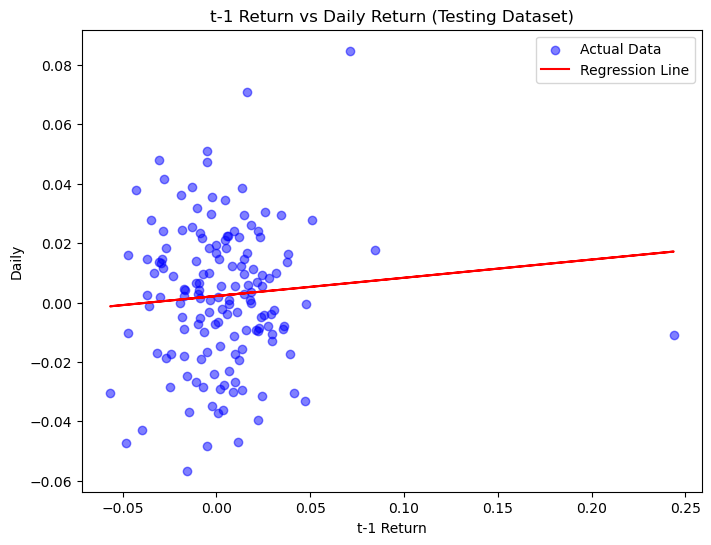

In [2658]:
x = df_regression[['t-1 Return']] # features
y = df_regression[['Daily Return']] # target

# split into training and testing datasets (ensure shuffle = False, because its a time series data)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# train the model
model = LinearRegression()
model.fit(x_train, y_train)

# predict on testing dataset
y_pred = model.predict(x_test)

# create subplots
fig, ax = plt.subplots(figsize=(8, 6))
# plot for testing dataset
ax.scatter(x_test, y_test, color='blue', alpha=0.5, label='Actual Data')
ax.plot(x_test, y_pred, color='red', label='Regression Line')
ax.set_xlabel('t-1 Return')
ax.set_ylabel('Daily')
ax.set_title('t-1 Return vs Daily Return (Testing Dataset)')
plt.legend()
plt.show()

From the results above, we observe that the predictions (as indicated by the red line) are significantly distant from the actual data points, demonstrating a poor fit. This suggests that there is no clear linear relationship between the t-1 return and the current Daily Return. The lack of a trend proves that when t-1 Return is used as the sole feature, it does not have a strong predictive power in forecasting future retruns.

This conclusion aligns with the findings from Question 2, where we explored the relationship between consecutive daily returns and found that returns on consecutive days are not strongly correlated.

**How does the inclusion of additional lagged returns (up to t-5) affect the predictive accuracy of a linear regression model for daily stock returns?**

In [2662]:
# create new dataframe
df_regression = df[['Daily Return']].copy()

# generate t-1 returns up to t-5 returns
for lag in range(1, 6):
    df_regression[f't-{lag} Return'] = df_regression['Daily Return'].shift(lag)

# drop null values
df_regression.dropna(inplace=True)

In [2664]:
# separate features and target
y = df_regression['Daily Return']
x = df_regression[[f't-{i} Return' for i in range(1, 6)]]

# dictionary to store MSEs
mse_dict = {}

In [2666]:
# perform rgression for each sets of features
for i in range(1, 6):
    # use the first n lags as features
    x_subset = x.iloc[:, :i]
    
    # split data into training and testing datasets (80/20 split)
    x_train, x_test, y_train, y_test = train_test_split(x_subset, y, test_size=0.2, shuffle=False)
    
    # train the model
    model = LinearRegression()
    model.fit(x_train, y_train)
    
    # make predictions
    y_pred = model.predict(x_test)
    
    # compute MSE
    mse = mean_squared_error(y_test, y_pred)
    
    # Store MSE for this model
    mse_dict[f't-{i}'] = mse

In [2668]:
# print MSEs
print(mse_dict)

{'t-1': 0.0005582479500335742, 't-2': 0.0005639464610305948, 't-3': 0.0005598766975972389, 't-4': 0.0005619808228745121, 't-5': 0.0005630545003810724}


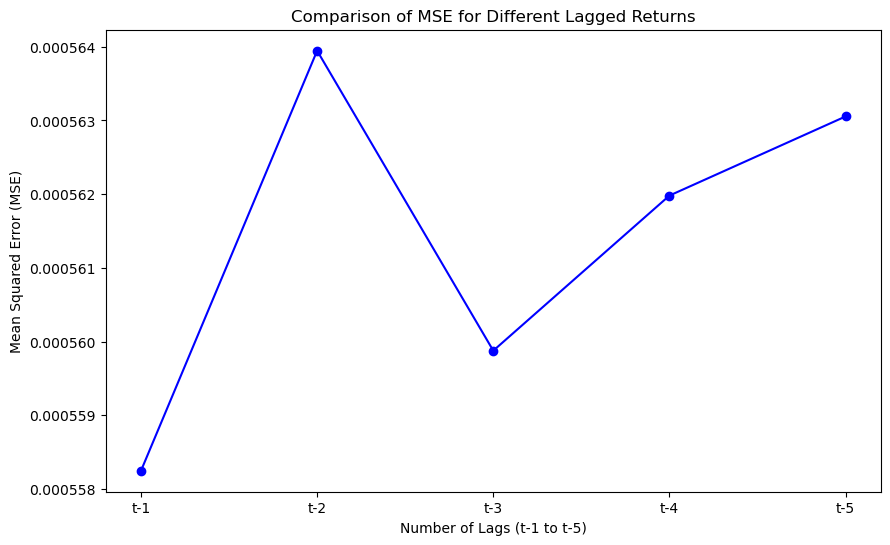

In [2670]:
# plott the MSE for each model
plt.figure(figsize=(10, 6))
plt.plot(list(mse_dict.keys()), list(mse_dict.values()), marker='o', linestyle='-', color='b')
plt.xlabel('Number of Lags (t-1 to t-5)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE for Different Lagged Returns')
plt.show()

From the plot, we observe that the linear regression model performs best when using only the t-1 Return as the feature, achieving the lowest MSE of 0.000558. Surprisingly, the model's performance worsens when both t-1 and t-2 Returns are used as features, with an MSE of 0.000564, which is the highest among the tested configurations. Similarly, the model performs poorly when t-1, t-2, t-3, t-4, and t-5 Returns are used as the feature. It performs the second worst with MSE of 0.000563. This suggests that adding additional lagged returns does not necessarily improve the model's accuracy and may lead to overfitting.

**Do volatility-based features, such as the high-low range and moving standard deviation, enhance the accuracy of predicting daily stock returns when combined with lagged return features?**

Given that Linear Regression with t-1 Return only was the best performing model, we are going to expand on this model by including volatility component as additional features, namely the t-1 High-Low Range and t-1 10-day Moving Standard Deviation.

In [2674]:
# add high-low range to the dataframe
df_regression['High-Low Range'] = df['High-Low Range']
# create lagged version
df_regression['t-1 High-Low Range'] = df_regression['High-Low Range'].shift(1)

# add 10-day rolling std into the dataframe
df_regression['10-day Moving Std'] = df['10-day Moving Std']
# create lagged version
df_regression['t-1 10-day Moving Std'] = df_regression['10-day Moving Std'].shift(1)

# drop null values
df_regression.dropna(inplace=True)

In [2676]:
# separate features and target
x = df_regression[['t-1 Return', 't-1 High-Low Range', 't-1 10-day Moving Std']]
y = df_regression['Daily Return']

# split data into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# train the model
model = LinearRegression()
model.fit(x_train, y_train)

# make prediction
y_pred = model.predict(x_test)

# compute the MSE
mse = mean_squared_error(y_test, y_pred)

# store the MSE in dictionary
mse_dict['vol'] = mse

# add the MSE 
print('The MSE of the model is', mse)

The MSE of the model is 0.0005670975001229008


{'t-1': 0.0005582479500335742, 't-2': 0.0005639464610305948, 't-3': 0.0005598766975972389, 't-4': 0.0005619808228745121, 't-5': 0.0005630545003810724, 'vol': 0.0005670975001229008}


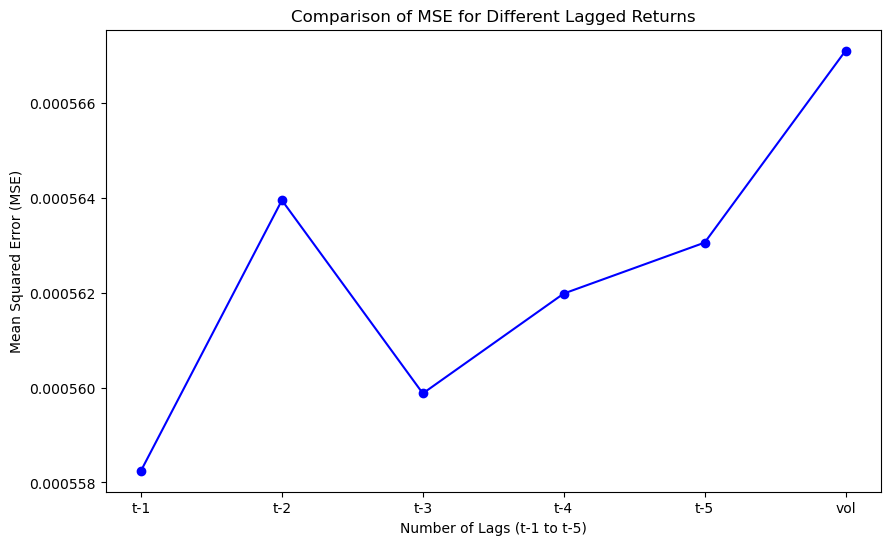

In [2678]:
# print MSEs
print(mse_dict)

# plot the MSE for each model
plt.figure(figsize=(10, 6))
plt.plot(list(mse_dict.keys()), list(mse_dict.values()), marker='o', linestyle='-', color='b')
plt.xlabel('Number of Lags (t-1 to t-5)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE for Different Lagged Returns')
plt.show()

The result shows that by incorporating additional volatility-related features (such as the t-1 High-Low Range and t-1 Moving Std) with t-1 Return is actually detrimental to predictive performance. For comparison, the model with only t-1 Return as the sole features produces an MSE of 0.000558, however by incorporating the volatility features, the MSE is actually higher at 0.000567. In fact, this MSE is higher than all of the 5 features configurations based on lagged returns. This suggests that adding volatility metrics actually worsen the model’s predictive accuracy.

Consistent with previous analysis, the simpler model is more efficient in capturing the predictive signal for daily returns. The additional complexity introduced by the volatility-related features appears to add noise rather than meaningful information in this context.

## 5. Summary and Conclusion

In this analysis, we explored 3 topics, including the Moving Average (MA) crossover strategy, the Monday Effect, and linear regression models.

- MA Crossover Strategy
In the MA crossover analysis, we learned that a balanced approach, particularly the medium-term configuration, yields the best performance. The short-term configuration (3-day MA and 10-day MA, 5 days holding period) is highly sensitive to price changes, generating many buy signals but with a low win rate and high volatility. In contrast, the long-term configuration (10-day MA and 40-day MA, 20 days holding period) capitalizes on sustained trends. The medium-term configuration (5-day MA and 20-day MA, 10 days holding period) strikes the best balance between responsiveness and holding period. It is able to avoid false signals, while gaining sizable returns on winning trades.

    For future work, the analysis could be performed on other stocks from different sectors or other asset classes such as commodities and forex. This could reveal whether the effectiveness of the MA crossover strategy varies across different securities. Moreover, one could conduct analysis on a wider range of moving average windows and holding periods, and reveal insights on which combinations yield the best performance under different market conditions (such as in a trending or sideways market phases). Lastly, volume data and sentiment analysis could be incroporated during crossover event. For example, a buy signal will only be generated when the MA crossover is couple with high trading volume and positive sentiment from the news or social media.

- The Monday Effect
We learned that the Monday Effect was not observed in NVDA stock. The correlation between Friday's and Monday's returns are weak and it is not statistically significant. This means that the returns on Friday is not a good predictor of Monday's return. Then, as we extend the analysis to other consecutive pairs, we observe a similar observation, where correlations are found to be weak with high p-values. Lastly, we learn that even in 'extreme' market events, Monday-Tuesday and Wednesday-Thursday pair have a moderate negative correlations. However, none of these correlations are statistically siginificant. This analysis challenges the notion of predictable return patterns, such as the Monday Effect, for NVDA stock.

    For future work, one could expand the analysis to stocks across different sectors. The aim would to determine if the Monday Effect and consecutive day patterns vary across industries. This could provide insights into whether the observed effects are universal or stock-specific. In addition, this analysis could be performed on various global markets, in particular on less efficient or emerging markets, where one may reveal more pronounced effects, as these markets tend to have greater volatility and are often more susceptible to behavioral biases. Lastly, one could expand the analysis beyond daily returns. For example, one could examine whether the cumulative return from Monday to Friday has any correlation with Monday's return. Alternatively, one could analyze a shorter time frame. For instance, the Monday Effect may only persist in the first few hours after the market opens.

- Linear Regression with Lagged Returns and Volatility Features
In this analysis, we discovered that using the t-1 Return as the sole feature resulted in the lowest Mean Squared Error (MSE). Interestingly, we learn that the inclusion of additional lagged returns (e.g., t-1, t-2, t-3, etc.) as features led to performance deterioration, suggesting that adding more lagged returns may introduce noise rather than valuable information. One key takeaway is that the t-1 return provides slightly more predictive power than longer lagged returns, though the overall predictive ability remains weak. This highlights the limited ability of past returns in predicting future returns. Additionally, as we add volatility-related features, it actually worsened the model's accuracy, which suggests that, in this case, volatility features add noise rather than improving predictive power.

    In short, the analysis emphasizes the importance of simplicity in predictive modeling for daily stock returns. Adding complexity through additional lagged returns or volatility indicators does not necessarily improve accuracy. Instead, focusing on the most recent return (t-1) proved to be the most effective approach.

    For future exploration, one could enhance the undersranding of the predictive power of lagged return and volatility indicators by performing the excercise on other stocks or group of stocks (i.e. indices or ETFs). This will help to determine whether the observed patterns are specific to NVDA or consistent across the broader market. Furthermore, one could integrate key macroeconomic variables (such as interest rates or inflation rates) as these variables are often used by investors in making investment decisions. Thus, capturing external influences that lagged returns and volatility metrics cannot. Lastly, one could use other measures of volatility. In particular, implied volatility which is derived from options prices that reflects the market expectations of future volatility. Thus, acting as a leading indicator that may provide forward-looking insights not captured by historical data.